# Markov prediction
In this notebook we will implement (arguably) the most simple form of sequence generation: a [bigram](https://en.wikipedia.org/wiki/Bigram) model where each subsequent token (character) is generated by sampling from the conditional probability distribution $P(X_t \mid X_{t-1}) \sim Multinomial_{X_{t-1}}(N_{tokens})$, i.e. every character (token) has an associated probility table for what the next character (token) will be. 'Training' proceeds through simple counting of observed character pairs.

We start with a very minimal implementation and then proceed to introduce some boilerplate for data loading, model forwarding, and training. Whereas this is not strictly necesarry for this model, it makes comparisons with later more complex models more straightforward. More importantly, our advanced implementation will be generalized to [n-grams](https://en.wikipedia.org/wiki/N-gram), i.e. higher order Markov chains. For example, an n-gram model of order two is $P(X_t \mid X_{t-1}, X_{t-2}) \sim Multinomial_{X_{t-1}, X_{t-2}}(N_{tokens})$. This will allow us to explore the limits of conditional probability lookup tables (e.g. in terms of performance and number of parameters).

In [22]:
# all dependencies for the entire notebook
import math
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from dataclasses import dataclass, field

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler

# Data

We use the tiny Shakespeare dataset to train a character level Markov model to predict text that looks very little like Shakespeare. All data is in one text file, which we download below.

In [23]:
# Download the tiny shakespeare dataset
!wget -nc https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

File ‘input.txt’ already there; not retrieving.



# Minimal bigram implementation
Below is a very minimal implementation of generating a text sample using Markov prediction: every next token is sampled according to a probability based only on the previous token. 'Training' consists of counting observed character pairs. We don't calculate a loss and model evaluation is based on intuition: whether or not the generated text feels like 'real' text.

  0%|          | 0/1115393 [00:00<?, ?it/s]

Sample:

I y ceptar, teen, fsinen yor pt winche,
Ofourt ut w.
Haslit IS:
ase ncond?
Y:
O, athery MNENERUTirsend oe, myoth t,
Tongathe,'s knoman t sthar my d IOMI maleicemameckend hinchis
Hsifee hadwite.'d at, and omise hedel:
T:

I coshie ams d;
Coens? tongened ch 



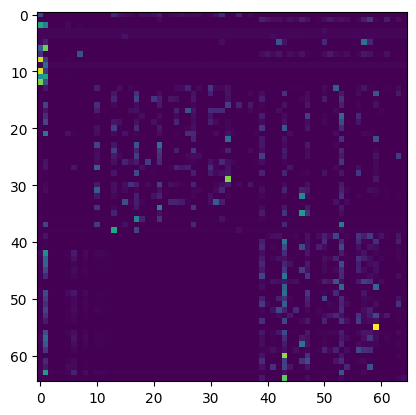

In [32]:
with open('input.txt') as fh:
    data = fh.read()

# create a sorted list of unique characters
chars = sorted(list(set(data)))
# count how many 'tokens'
vocab_size = len(chars)
# map characters to integers
encode = { ch:i for i,ch in enumerate(chars) }
# map integers to characters
decode = { i:ch for i,ch in enumerate(chars) }

# initialize counts with ones for automatic laplace/additive smoothing: https://en.wikipedia.org/wiki/Additive_smoothing
counts = torch.ones(vocab_size, vocab_size)

# 'train' (i.e. count) for n steps (i.e. character pairs)
n_train_chars = len(data) - 1
for i in trange(n_train_chars):
    token_i = encode[data[i]]
    token_j = encode[data[i+1]]
    counts[token_i][token_j] += 1

# divide by row sums to get transition probabilities
probs = counts / counts.sum(dim=1, keepdim=True)

# start our sample with token 0 (i.e. the newline character \n)
sample = [0]
sample_n_tokens = 256

# for n steps, sample a token from the distribution belonging the last token in the current sample and add it to the sample
for _ in range(sample_n_tokens):
    last_token = sample[-1]
    next_token_probs = probs[last_token]
    next_token = torch.multinomial(next_token_probs, num_samples=1)
    sample.append(next_token.item())

# decode sample tokens into characters
decoded_sample = ''.join(decode[token] for token in sample)
print(f'Sample:\n{decoded_sample}\n')

# plot observed transition probabilities
plt.imshow(probs)

### Exercise 1

Experiment with different numbers of training steps (by setting `n_train_chars` in the code above), e.g. 100, 1000, or 10,000. When do you start seeing some structure appearing in the generated samples? What about if you 'train' on the entire dataset? (i.e. `n_train_chars = len(data) - 1`)?

# Advanced n-gram implementation

Clearly bigrams pick up some structure from a large enough text, but are not powerful enough to generate realistic sentences. Below we implement the same counting principle for n-gram models. To do so, we create a character level tokenizer, a dataset class that returns tensors of a certain order, and a model class that takes care of our most commonly used procedures (e.g. parameter initialization, prediction, calculating a loss score, and generating novel text). These main building blocks (tokenizer, dataset, model) look very similar to what we will use in the rest of the week when we build more advanced models based on neural networks.

## Data

In [25]:
class CharacterTokenizer:
    """Character level tokenizer that enumerates unique characters in a training text"""
    def __init__(self, encoding_dict: dict[str, int]=None):
        if encoding_dict is None:
            self.encoding_dict = dict()
        else:
            self.encoding_dict = encoding_dict

    def __repr__(self):
        return f'CharacterTokenizer(vocab_size={self.vocab_size})'

    @property
    def decoding_dict(self) -> dict[int, str]:
        """Decoding dict is implemented as property to automatically sync with changed encoding dict"""
        return {token:char for char,token in self.encoding_dict.items()}

    @property
    def vocab_size(self) -> int:
        return len(self.encoding_dict)

    def get_vocab(self) -> dict[str, int]:
        return self.encoding_dict

    def train(self, data: str) -> None:
        """Train on a piece of text by enumerating unique characters"""
        chars = sorted(set(data))
        self.encoding_dict = {char:token for token,char in enumerate(chars)}

    def encode(self, data: str) -> list[int]:
        """Convert text to tokens"""
        return [self.encoding_dict.get(char, -1) for char in data]

    def decode(self, tokens: list[int]) -> str:
        """Convert tokens to text"""
        return ''.join(self.decoding_dict.get(token, '<unk>') for token in tokens)

class CharacterDataset:
    def __init__(self, data: str, tokenizer: CharacterTokenizer, order: int=1):
        assert order > 0, 'Order must be > 1'
        self.data = data
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.get_vocab())
        self.order = order

    def __repr__(self):
        n_chars = len(self.data)
        vocab_size = self.vocab_size
        order = self.order
        return f'CharacterDataset({n_chars=}, {vocab_size=}, {order=})'

    @classmethod
    def from_textfile(cls, filename: str, order: int=1) -> 'CharacterDataset':
        tokenizer = CharacterTokenizer()
        with open(filename, 'r') as fh:
            data = fh.read()
            tokenizer.train(data)
            return cls(data, tokenizer, order=order)

    def train_test_split(self, train_percentage: float=0.8) -> tuple['CharacterDataset','CharacterDataset']:
        n_train_chars = int(train_percentage * len(self.data))

        train_data = self.data[:n_train_chars]
        train_dataset = CharacterDataset(train_data, self.tokenizer, self.order)

        test_data = self.data[n_train_chars:]
        test_dataset = CharacterDataset(test_data, self.tokenizer, self.order)

        return train_dataset, test_dataset

    def __len__(self) -> int:
        return len(self.data) -  self.order

    def __getitem__(self, idx: int) -> torch.tensor:
        # grab a chunk of block_size characters from the data
        chunk = self.data[idx:idx + self.order + 1]
        # encode every character to an integer
        tokens = self.tokenizer.encode(chunk)
        # convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        # return relevant tokens based on indices
        x = tokens[:-1]
        y = tokens[-1:]
        return x,y

dataset = CharacterDataset.from_textfile('./input.txt')
train_dataset,test_dataset = dataset.train_test_split()
len(train_dataset),len(test_dataset)

(892314, 223078)

## Model
Below we generalize the bigram counting model to work on n-grams of arbitrary order n. We create a class to wrap parameters and add functionality for 'forwarding' the model (i.e. calculating next token probabilities), calculating a loss score, and generating token samples.

In [33]:
class NGramModel(nn.Module):
    """Very simple model for next character prediction by counting observed n-grams"""
    def __init__(self, vocab_size, order=1):
        assert order > 0, 'Order must be > 1'
        super().__init__()
        self.order = order
        # counting character pairs in a vocab_size ** (order + 1) table
        self.counts = torch.ones([vocab_size] * (order + 1))

    def __repr__(self) -> str:
        order = self.order
        return f'NGramModel({order=})'

    @property
    def probs(self) -> torch.tensor:
        """Normalize counts to probabilities by dividing over row sums"""
        return self.counts / self.counts.sum(dim=-1, keepdim=True)

    def forward(self, idx: torch.tensor, targets: torch.tensor=None) -> torch.tensor:
        probs = self.probs[[*idx.T]]
        loss = None if targets is None else F.cross_entropy(probs, targets.view(-1))
        return probs,loss

    def generate(self, sample_length: int=256) -> list[int]:
        """Generate samples"""
        idx = torch.zeros(self.order, dtype=torch.long)
        for _ in trange(sample_length, desc='Sampling'):
            probs,_ = model(idx[-self.order:][None])
            new_idx = torch.multinomial(probs[0], num_samples=1)
            idx = torch.hstack([idx, new_idx])

        return idx.tolist()

dataset = CharacterDataset.from_textfile('./input.txt', order=3)
model = NGramModel(vocab_size = dataset.vocab_size, order = dataset.order)

print(dataset)
print(model)

# Show a sample from an untrained model
sample = model.generate(sample_length=64)
print(dataset.tokenizer.decode(sample))

CharacterDataset(n_chars=1115394, vocab_size=65, order=3)
NGramModel(order=3)


Sampling:   0%|          | 0/64 [00:00<?, ?it/s]




nBP;yGJZe
jVpptoNJvMd h
zovi.NIdx;uqQ nW:foz$ytzfM?iqOCRP-jOR$n-


## Training
Note that whereas we can call this 'training', all the code below does is count character pairs (triples, etc...) and update the pair count table of the model.

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

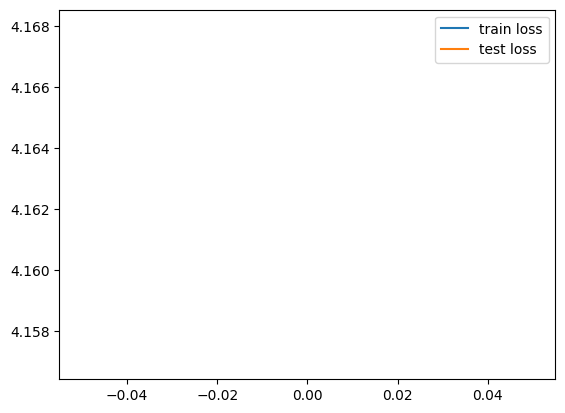

In [34]:
dataset = CharacterDataset.from_textfile('./input.txt', order=1)
train_dataset, test_dataset = dataset.train_test_split()

model = NGramModel(dataset.vocab_size, dataset.order)

n_train_steps = 1_000
batch_size = 100

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, num_samples=n_train_steps * batch_size),
    batch_size=batch_size
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=True), # test dataset is relatively small so we might need to sample more than once
    batch_size=batch_size
)
test_dataloader = iter(test_dataloader)

train_loss = []
test_loss = []

for i, train_batch in enumerate(tqdm(train_dataloader, desc='Training')):
    for x,y in zip(*train_batch):
          model.counts[[*x, y]] += 1
    if i % 1_000 == 0:
        test_batch = next(test_dataloader)
        test_loss.append(model(*test_batch)[1])
        train_loss.append(model(*train_batch)[1])

plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()

## Evaluation
The model has learned some structure, e.g. there are probably a bit more newlines and a colon is always followed by a newline.

In [131]:
sample = model.generate()
print(dataset.tokenizer.decode(sample))

Sampling:   0%|          | 0/256 [00:00<?, ?it/s]




CAMILLehzqsrhTDjgAYA;yud
And thou save word, do name we my power i' Jf'nkF MbQ,wKhrMvZvGiMnNS?oi3peiaKTJAnH?jU;FEqyvWpQQkRG.z:gmE,OfHaz
VyV;;JdNMb'll not age, and treath?lb:BQ&XHD&.P,y's tones
Than manot curbs, fould he guarry two marr'd.

BENVOLUMNIA:
Exc


### Exercise 2
Fit n-gram models of order 1, 2, and 3, note the training and test loss, and evaluate a few generated samples. What do you observe? Does an n-gram model of order 3 result in reasonable text?

### Exercise 3
How many parameters do you need for an n-gram model of order 4? What do you expect the training loss will be (extrapolate from the results you got in excercise 2)?

## Answers

### Exercise 1
100 and 100 are generally not enough; 10,000 picks up some structure, such as repeated newlines and sometimes word fragments. Training on the whole dataset generally produces gibberish, but some interesting structure emerges, such as repeated capital letters, interpunction at the end of sentences, and word fragments.

### Exercise 2
- Order 1: train and test loss of ~4.07, samples in line with exercise 1
- Order 2: train loss 3.94, test loss slightly higher, samples produce actual words similar to Shakespeare, such as QUEEN
- Order 3: train loss 3.80, test loss 3.85, samples become hit and miss. One approach is to train for much longer, which generated the sample below:
> SICINIUS:
> Some King was part ind law to-day.
>
> KINGHAM:
> Wher that you, or broung Herefusin, cons, I life
> But those compassance
> Why, have threen resolding.
>
> Nurs
> Since that heir pers?
>
> CAMILLO:
> And Citizens bothe in preve
> Go, love;
> For him, anous sun than an

Additional note: higher order models converge slower, they need far more data to work.

### Exercise 3

65 ** 4 = 17.850.625 (~18M) parameters. Assuming our loss drops again by ~0.15 this is does not seem very efficient.